In [3]:
# Apprentice Chef Case - (Carlos) Andres Restrepo Ayala - Hult MsBA 2021 Class
# Prediction Model
# Assumption: The data delivered by marketing team was collected and stored correctly

"""
    Docstring:
    
    A) Purpose: This code tests different classification models to predict 
    how well perform a cross selling promotion where subscribers receive
    a half bottle of wine from a local California vineyard every Wednesday.
    
    The acceptance of the promotion is stored as a binary variable 
    'CROSS_SELL_SUCCESS' an tested using the models: Logistic Regression, 
    Classification Tree, KNN, Random Forest and GBM and used hyperparameter
    tuning to improve the models. The models are measured based on the AUC 
    result of the test splited data after run the set of models.
    
    Some line of code with "print" sentences were turn into comments after 
    were used to check the correct function of the code as well as the hyperparameter
    tuning cells. You can turn active those line to see intermediate results .
   
    B) Bugs or malfunction as the code expected.
    No bugs are detected after runing the code.
"""    
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # also <from matplotlib import pyplot as plt>
import seaborn as sns
import csv
import statsmodels.formula.api as smf# linear regression (statsmodels)
from sklearn.model_selection import train_test_split # train/test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus   
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import time 
#Start timer
start = time.time()

In [4]:
########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [5]:
# initial preparing the dataframe

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# reading the dataframe
file ='./datasets/Apprentice_Chef_Dataset.xlsx'
df_meals = pd.read_excel(io = file)

# renaming LARGEST_ORDER_SIZE variable
df_meals= df_meals.rename(columns = {'LARGEST_ORDER_SIZE': 'AVG_MEALSORDER_PER_CUSTOMER'})

# droping categorical variables for linear modeling
df_meals = df_meals.drop(['NAME', 'FIRST_NAME','FAMILY_NAME'],    # Temporary no include 'EMAIL' from list of droped
                         axis = 1)

In [6]:
# feature engineering Email
# This part of the code just can be run once

# splitting emails

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in df_meals.iterrows():
    
    # splitting email domain at '@'
    split_email = df_meals.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)

# renaming column to concatenate
email_df.columns = [ '0' , 'EMAIL_DOMAIN' ]


# defining Emails Domain Groups
professional_email_domains = ['@mmm.com', '@amex.com', '@apple.com',
                              '@boeing.com', '@caterpillar.com', '@chevron.com',
                             '@cisco.com', '@cocacola.com', '@disney.com',
                             '@dupont.com', '@exxon.com', '@ge.org', 
                              '@goldmansacs.com', '@homedepot.com', '@ibm.com',
                             '@intel.com', '@jnj.com', '@jpmorgan.com', 
                              '@mcdonalds.com', '@merck.com', '@microsoft.com',
                             '@nike.com', '@pfizer.com', '@pg.com', 
                              '@travelers.com', '@unitedtech.com', 
                              '@verizon.com','@visa.com', '@walmart.com']

personal_email_domains     = ['@gmail.com', '@yahoo.com', '@protonmail.com']

junk_email_domains         = ['@me.com', '@aol.com', '@hotmail.com', 
                              '@live.com', '@msn.com', '@passport.com']

# resetting placeholderlist
placeholder_lst = []

# looping to group observations by domain type
for domain in email_df['EMAIL_DOMAIN']:
        if  '@' + domain in professional_email_domains:
            placeholder_lst.append('PROFESSIONAL')
        
        elif '@' + domain in personal_email_domains:
            placeholder_lst.append('PERSONAL')
            
        elif '@' + domain in junk_email_domains:
            placeholder_lst.append('JUNK')
            
        else:
            placeholder_lst.append('NEW_DOMAIN')

# concatenating with original DataFrame
df_meals['DOMAIN_GROUP'] = pd.Series(placeholder_lst)

# checking results
df_meals['DOMAIN_GROUP'].value_counts()

# one hot encoding 
one_hot_email_domain       = pd.get_dummies(df_meals['DOMAIN_GROUP'])

# dropping categorical variables after they've been encoded
df_meals = df_meals.drop('DOMAIN_GROUP', axis = 1)

# joining codings together
df_meals = df_meals.join([one_hot_email_domain])

# removing original EMAIL variable
df_meals = df_meals.drop(['EMAIL'], axis = 1)

In [7]:
# feature engineering

# Recoding Explanatory variables using dummy variables

# Dummy variables for recoding
df_meals['WEEKLY_SUBSCRIPTION']  = 0
df_meals['SAW_INSTRUCTIONS']     = 0
df_meals['TOOK_MASTERCLASS']     = 0
df_meals['DELIVERY_MIN_ONTIME']  = 0
df_meals['TOOK_INSTRUCTIONS']    = 0
df_meals['CANCEL_ORDERS']        = 0
df_meals['AVR_ORDER_ABOVE_MEAN'] = 0
df_meals['TOTAL_LOGINS']         = 0
df_meals['REVENUE_PER_CUSTOMER'] = 0
df_meals['REVENUE_PER_MEAL']     = 0
df_meals['POSIBLE_WINE']         = 0

# Iterating over each original column to
# change values in the new feature columns
for index, value in df_meals.iterrows():
    
    # WEEKLY_PLAN
    if df_meals.loc[index, 'WEEKLY_PLAN'] > 0:
        df_meals.loc[index, 'WEEKLY_SUBSCRIPTION'] = 1
        
    # AVG_PREP_VID_TIME
    if df_meals.loc[index, 'AVG_PREP_VID_TIME'] > 0:
        df_meals.loc[index, 'SAW_INSTRUCTIONS'] = 1
    
    # MASTER_CLASSES_ATTENDED
    if df_meals.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
        df_meals.loc[index, 'TOOK_MASTERCLASS'] = 1
        
    # Delivery Always at least on time 
    if df_meals.loc[index, 'EARLY_DELIVERIES'] > 0 and \
        df_meals.loc[index, 'LATE_DELIVERIES'] == 0:
            df_meals.loc[index, 'DELIVERY_MIN_ONTIME'] = 1
    
    # Instruction from video and masterclass  
    if df_meals.loc[index, 'AVG_PREP_VID_TIME'] > 0 and \
        df_meals.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
            df_meals.loc[index, 'TOOK_INSTRUCTIONS'] = 1

    
    # Canceling orders
    if df_meals.loc[index, 'CANCELLATIONS_BEFORE_NOON'] > 0 and \
        df_meals.loc[index, 'CANCELLATIONS_AFTER_NOON'] > 0:
            df_meals.loc[index, 'CANCEL_ORDERS'] = 1

    
    # Average order more than 3 times
    if df_meals.loc[index, 'AVG_MEALSORDER_PER_CUSTOMER'] > 3: 
            df_meals.loc[index, 'AVR_ORDER_ABOVE_MEAN'] = 1
            
    # Total logins using different devices
    df_meals.loc[index, 'TOTAL_LOGINS'] = df_meals.loc[index, 'MOBILE_LOGINS'] + \
        df_meals.loc[index, 'PC_LOGINS']
    
    # Calculating revenue per customer
    df_meals.loc[index, 'REVENUE_PER_CUSTOMER'] = df_meals.loc[index, 'REVENUE'] / \
        df_meals.loc[index, 'AVG_MEALSORDER_PER_CUSTOMER']
    
    # Calculating revenue per meal
    df_meals.loc[index, 'REVENUE_PER_MEAL'] = df_meals.loc[index, 'REVENUE'] / \
        df_meals.loc[index, 'TOTAL_MEALS_ORDERED']
    
    # Estimating order which possible included wine as Revene_per_meal above 30
    # 30 = min price with wine plus max price of food per meal
    if df_meals.loc[index , 'REVENUE_PER_MEAL'] > 30:
        df_meals.loc[index, 'POSIBLE_WINE'] = 1
        

In [8]:
# featuring engineering

# recoding TOTAL_PHOTOS_VIEWED - counting the number of zeroes for 
photos_zeroes   = len(df_meals['TOTAL_PHOTOS_VIEWED'][df_meals['TOTAL_PHOTOS_VIEWED'] == 0]) # TOTAL PHOTOS

# printing a table of the results
#print(f"""
#                 No\t\tYes
#               ---------------------
#Photos       | {photos_zeroes}\t\t{len(df_meals) - photos_zeroes}
#""")

# recogind the variable
df_meals['PHOTOS_VIEWED']    = 0


# Iterating over each original column to
# change values in the new feature columns
for index, value in df_meals.iterrows():
    
    # WEEKLY_PLAN
    if df_meals.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        df_meals.loc[index, 'PHOTOS_VIEWED'] = 1

In [9]:
# Normalizing the dataframe

# creating a copy of the dataframe
df_meals_norm = pd.DataFrame(df_meals).copy()

# creating the list of columns to normalize
column_names_to_normalize = ['REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH',
                            'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',
                            'AVG_TIME_PER_SITE_VISIT', 'CANCELLATIONS_BEFORE_NOON',
                            'CANCELLATIONS_AFTER_NOON', 'PC_LOGINS', 'MOBILE_LOGINS',
                            'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES',
                            'AVG_PREP_VID_TIME', 'AVG_MEALSORDER_PER_CUSTOMER',
                            'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING',
                            'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED',
                            'TOTAL_LOGINS', 'REVENUE_PER_CUSTOMER', 
                            'REVENUE_PER_MEAL']

# creating the object to normalize
x = df_meals_norm[column_names_to_normalize].values

# Instantiating the scales
min_max_scaler = MinMaxScaler()

# fitting and transformind the variables
x_scaled = min_max_scaler.fit_transform(x)

# setting as dataframe
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df_meals_norm.index)

# saving the results in the copied dataframe
df_meals_norm[column_names_to_normalize] = df_temp

In [11]:
df_meals_norm

# converting model_performance into a DataFrame
df_meals_norm = pd.DataFrame(df_meals_norm)


# sending model results to Excel
df_meals_norm.to_excel('./datasets/classification_df_meals_norm.xlsx',
                           index = False)

In [8]:
# preparing data for classification models using SciKit-learn with explanatory sets of variables

# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : ['REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 
                   'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',
                   'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER',
                   'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON',
                   'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS',
                   'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES',
                   'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',
                   'AVG_MEALSORDER_PER_CUSTOMER', 'MASTER_CLASSES_ATTENDED',
                   'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT',
                   'TOTAL_PHOTOS_VIEWED', 'JUNK', 'PERSONAL', 'PROFESSIONAL',
                   'WEEKLY_SUBSCRIPTION', 'SAW_INSTRUCTIONS', 'TOOK_MASTERCLASS',
                   'DELIVERY_MIN_ONTIME', 'TOOK_INSTRUCTIONS', 'CANCEL_ORDERS',
                   'AVR_ORDER_ABOVE_MEAN', 'TOTAL_LOGINS', 'REVENUE_PER_CUSTOMER',
                   'REVENUE_PER_MEAL', 'POSIBLE_WINE', 'PHOTOS_VIEWED'],
 

# significant variables after droping the transformed variables
 'logit_sig_1'    : ['REVENUE', 'UNIQUE_MEALS_PURCH', 
                   'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',
                   'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER',
                   'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON',
                   'TASTES_AND_PREFERENCES', 'EARLY_DELIVERIES', 
                   'LATE_DELIVERIES', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER',
                   'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT',
                   'TOTAL_PHOTOS_VIEWED', 'JUNK', 'PERSONAL', 'PROFESSIONAL',
                   'WEEKLY_SUBSCRIPTION', 'SAW_INSTRUCTIONS', 'TOOK_MASTERCLASS',
                   'DELIVERY_MIN_ONTIME', 'TOOK_INSTRUCTIONS', 
                   'AVR_ORDER_ABOVE_MEAN', 'TOTAL_LOGINS', 'REVENUE_PER_CUSTOMER',
                   'REVENUE_PER_MEAL', 'POSIBLE_WINE', 'PHOTOS_VIEWED'],
    
    
 # significant variables in the basic logistic regression
'logit_sig_2'  : [ 'CONTACTS_W_CUSTOMER_SERVICE', 'MOBILE_NUMBER', 
                   'CANCELLATIONS_BEFORE_NOON', 'TASTES_AND_PREFERENCES',
                   'JUNK', 'POSIBLE_WINE' ]


}

In [9]:
# train/test split with the full model
df_meals_norm_data   =  df_meals_norm.loc[ : , candidate_dict['logit_sig_1']]
df_meals_norm_target =  df_meals_norm.loc[ : , 'CROSS_SELL_SUCCESS']

# this is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            df_meals_norm_data,
            df_meals_norm_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = df_meals_norm_target)

**Logistic Regression** model

In [10]:
# First Logistic regression using SciKit

# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)

# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)

# SCORING the results
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)

# Confusion matrix for fist logistic regression

# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")

# Calculatin AUC

# area under the roc curve (auc)
print(f""" AUC score: {roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4)}""")


# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

LogReg Training ACCURACY: 0.7238
LogReg Testing  ACCURACY: 0.7269
LogReg Train-Test Gap   : 0.0031
[[ 53 103]
 [ 30 301]]

True Negatives : 53
False Positives: 103
False Negatives: 30
True Positives : 301

 AUC score: 0.6246


**Hyperparameter tuning** for Logistic Regression Model

In [11]:
########################################
# RandomizedSearchCV
########################################

# declaring a hyperparameter space
# C_space          = pd.np.arange(0.1, 10.0, 0.1)
# warm_start_space = [True, False]
# solver_space     = ['newton-cg', 'sag', 'lbfgs', 'liblinear', 'saga']


# creating a hyperparameter grid
# param_grid = {'C'          : C_space,
#               'warm_start' : warm_start_space,
#               'solver'     : solver_space}

# INSTANTIATING the model object without hyperparameters
# lr_tuned = LogisticRegression(random_state = 219,
#                               max_iter     = 1000)


# GridSearchCV object
# lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 250,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
# lr_tuned_cv.fit(df_meals_norm_data, df_meals_norm_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
# print("Tuned Parameters  :", lr_tuned_cv.best_params_)
# print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

Result of **Hyperparameter tuning** for Logistic Regression

Tuned Parameters  : {'warm_start': False, 'solver': 'sag', 'C': 9.6}\
Tuned CV AUC      : 0.6314

In [12]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
lr_tuned = LogisticRegression(solver       = 'sag',
                              C            = 9.6,
                              warm_start   = False,
                              random_state = 219)

# FIT step is not needed
# FITTING the training data
lr_tuned_fit = lr_tuned.fit(df_meals_norm_data, df_meals_norm_target)

# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(x_test)

# SCORING the results
print('LR Tuned Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('LR Tuned Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('LR Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

# unpacking the confusion matrix
lr_tuned_tn, \
lr_tuned_fp, \
lr_tuned_fn, \
lr_tuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn}
False Positives: {lr_tuned_fp}
False Negatives: {lr_tuned_fn}
True Positives : {lr_tuned_tp}
""")



LR Tuned Training ACCURACY: 0.7313
LR Tuned Testing  ACCURACY: 0.7372
LR Tuned AUC Score        : 0.6389

True Negatives : 57
False Positives: 99
False Negatives: 29
True Positives : 302



C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


**Classification tree** model

In [13]:
# first classification tree

# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)

# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")

Full Tree Training ACCURACY: 1.0
Full Tree Testing ACCURACY : 0.5955
Full Tree AUC Score: 0.5414

True Negatives : 61
False Positives: 95
False Negatives: 102
True Positives : 229



**Pruned Tree**  Model

In [14]:
# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 8,
                                     min_samples_leaf = 16,
                                     random_state = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)

# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")

Training ACCURACY: 0.7642
Testing  ACCURACY: 0.7023
AUC Score        : 0.6217

True Negatives : 62
False Positives: 94
False Negatives: 51
True Positives : 280



**Hyperparameter tuning** for Classification Tree Model

In [15]:
# # declaring a hyperparameter space
# criterion_space = ['gini', 'entropy']
# splitter_space  = ['best', 'random']
# depth_space     = pd.np.arange(1, 8, 1)
# leaf_space      = pd.np.arange(1, 100, 1)


# # creating a hyperparameter grid
# param_grid = {'criterion'        : criterion_space,
#               'splitter'         : splitter_space,
#               'max_depth'        : depth_space,
#               'min_samples_leaf' : leaf_space}


# # INSTANTIATING the model object without hyperparameters
# tuned_tree = DecisionTreeClassifier(random_state = 219)


# # RandomizedSearchCV object
# tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
#                                    param_distributions   = param_grid,
#                                    cv                    = 3,
#                                    n_iter                = 1000,
#                                    random_state          = 219,
#                                    scoring = make_scorer(roc_auc_score,
#                                              needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_tree_cv.fit(df_meals_norm_data, df_meals_norm_target)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_tree_cv.best_params_)
# print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

Result of **Hyperparameter tuning** for Classification Tree:

Tuned Parameters  : {'splitter': 'random', 'min_samples_leaf': 14, 'max_depth': 5, 'criterion': 'entropy'}\
Tuned Training AUC: 0.6265

In [16]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
tree_tuned =  DecisionTreeClassifier(max_depth        = 5,
                                     min_samples_leaf = 14,
                                     splitter         = 'random',
                                     criterion        = 'entropy',
                                     random_state     = 219)

# FIT step is not needed
tree_tuned_fit  = tree_tuned.fit(df_meals_norm_data, df_meals_norm_target)

# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)

# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = tree_tuned_pred).round(4) # auc

# unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")

Training ACCURACY: 0.7437
Testing  ACCURACY: 0.7515
AUC Score        : 0.6495

True Negatives : 57
False Positives: 99
False Negatives: 22
True Positives : 309



**KNN** Classification Model

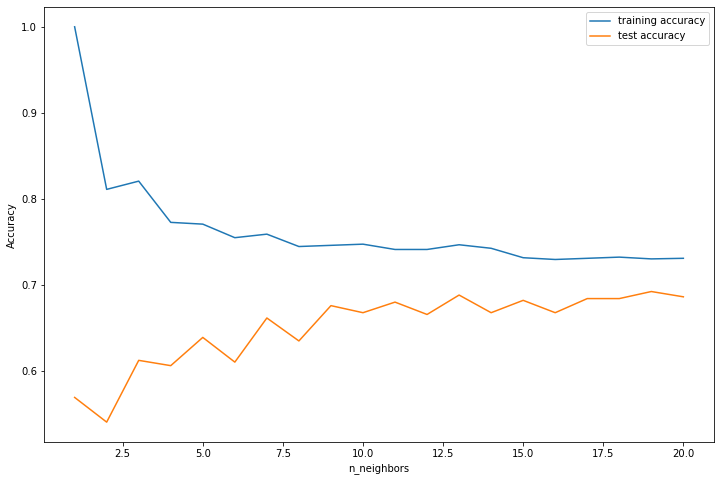

The optimal number of neighbors is: 19


In [17]:
########################################
# optimal_neighbors
########################################
def optimal_neighbors(X_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(X_data)
        X_scaled           = scaler.transform(X_data)
        X_scaled_df        = pd.DataFrame(X_scaled)
        X_data             = X_scaled_df



    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data        = df_meals_norm_data,
                                  y_data        = df_meals_norm_target,
                                  response_type = 'class')



In [18]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_meals_norm_data)


# TRANSFORMING the data
x_scaled     = scaler.transform(df_meals_norm_data)


# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 

# train-test split with the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            df_meals_norm_target,
            random_state = 219,
            test_size = 0.25,
            stratify = df_meals_norm_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = (knn_fit.predict_proba(x_test_scaled)[:,1]>=0.64).astype(int)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))

# saving scoring data
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)


# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)

Training ACCURACY: 0.7245
Testing  ACCURACY: 0.7084
AUC Score        : 0.6163


**Random Forest** model

In [19]:
# first random forest model

# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)

# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(x_test, y_test).round(4))


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")

Training ACCURACY: 1.0
Testing  ACCURACY: 0.7043
AUC Score        : 0.5808

True Negatives : 37
False Positives: 119
False Negatives: 25
True Positives : 306



**Hyperparameter tuning** Random Forest Model

In [20]:
# # FITTING the training data
# rf_default_fit = rf_default.fit(x_train, y_train)


# # PREDICTING based on the testing set
# rf_default_fit_pred = rf_default_fit.predict(x_test)


# # declaring a hyperparameter space
# estimator_space  = pd.np.arange(100, 1100, 250)
# leaf_space       = pd.np.arange(1, 31, 10)
# criterion_space  = ['gini', 'entropy']
# bootstrap_space  = [True, False]
# warm_start_space = [True, False]
# depth_space      = pd.np.arange(1, 8, 1)

# # creating a hyperparameter grid
# param_grid = {'n_estimators'     : estimator_space,
#               'min_samples_leaf' : leaf_space,
#               'criterion'        : criterion_space,
#               'bootstrap'        : bootstrap_space,
#               'warm_start'       : warm_start_space,
#               'max_depth'        : depth_space}


# # INSTANTIATING the model object without hyperparameters
# forest_grid = RandomForestClassifier(random_state = 219)


# # GridSearchCV object
# forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                                param_distributions = param_grid,
#                                cv         = 3,
#                                n_iter     = 1000,
#                                scoring    = make_scorer(roc_auc_score,
#                                             needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# forest_cv.fit(df_meals_norm_data, df_meals_norm_target)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", forest_cv.best_params_)
# print("Tuned Training AUC:", forest_cv.best_score_.round(4))

**Hyperparameter tuning** for Random Forest

Tuned Parameters  : {'warm_start': True, 'n_estimators': 350, 'min_samples_leaf': 11, 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}\
Tuned Training AUC: 0.5966

In [21]:
# building a model based on hyperparameter tuning results

# copy/pasting in the best_estimator_ results
# to avoid running another RandomizedSearch
forest_tuned = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=11, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=219,
                       verbose=0, warm_start=True)


# FITTING the model object
forest_tuned_fit = forest_tuned.fit(df_meals_norm_data, df_meals_norm_target)


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)

# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                   y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")

Forest Tuned Training ACCURACY: 0.7601
Forest Tuned Testing  ACCURACY: 0.7659
Forest Tuned AUC Score        : 0.6516

True Negatives : 52
False Positives: 104
False Negatives: 10
True Positives : 321



**GBM** model

In [22]:
# INSTANTIATING the model object without hyperparameters
full_gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', full_gbm_default_fit.score(x_train, y_train).round(4))
print('Testing ACCURACY :', full_gbm_default_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_default_pred).round(4))

# scoring the train and test
gbm_train_score = full_gbm_default_fit.score(x_train, y_train).round(4)
gbm_test_score = full_gbm_default_fit.score(x_test, y_test).round(4)

# scoring the AUC
gbm_auc = roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_default_pred).round(4)

# unpacking the confusion matrix
gbm_default_tn, \
gbm_default_fp, \
gbm_default_fn, \
gbm_default_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_default_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_default_tn}
False Positives: {gbm_default_fp}
False Negatives: {gbm_default_fn}
True Positives : {gbm_default_tp}
""")

Training ACCURACY: 0.8005
Testing ACCURACY : 0.7248
AUC Score        : 0.6146

True Negatives : 48
False Positives: 108
False Negatives: 26
True Positives : 305



**Hyperparameters tuning** for GBM model

In [23]:
# # declaring a hyperparameter space
# learn_space        = pd.np.arange(0.1, 2.0, 0.2)
# estimator_space    = pd.np.arange(100, 200, 25)
# depth_space        = pd.np.arange(1, 8, 2)
# warm_start_space   = [True, False]

# # creating a hyperparameter grid
# param_grid = {'learning_rate' : learn_space,
#               'max_depth'     : depth_space,
#               'n_estimators'  : estimator_space,
#               'warm_start'    : warm_start_space}


# # INSTANTIATING the model object without hyperparameters
# full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# # GridSearchCV object
# full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
#                            param_distributions = param_grid,
#                            cv                  = 3,
#                            n_iter              = 500,
#                            random_state        = 219,
#                            scoring             = make_scorer(roc_auc_score,
#                                                  needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# full_gbm_cv.fit(df_meals_norm_data, df_meals_norm_target)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", full_gbm_cv.best_params_)
# print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

In [24]:
# INSTANTIATING the model object without hyperparameters

# I made several attempts to hyperparameter tuning
gbm_tuned = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.7000000000000001, loss='deviance',
                           max_depth=1, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=219, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=True)

# FIT step is needed as we are not using .best_estimator
gbm_tuned_fit = gbm_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)

# SCORING the results
print('Training ACCURACY:', gbm_tuned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', gbm_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))


# scoring the train and test
gbm_tuned_train_score = gbm_tuned_fit.score(x_train, y_train).round(4)
gbm_tuned_test_score  = gbm_tuned_fit.score(x_test, y_test).round(4)





# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")

Training ACCURACY: 0.7649
Testing  ACCURACY: 0.7064
AUC Score        : 0.6044

True Negatives : 50
False Positives: 106
False Negatives: 37
True Positives : 294



**Random Forest** model with a changed alpha treshold 

In [25]:
# first random forest model

# INSTANTIATING a random forest model with default values
rf_default_ca = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

# FITTING the training data
rf_default_fit_ca = rf_default_ca.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred_ca = (rf_default_fit_ca.predict_proba(x_test)[:,1]>=0.65).astype(int)

# SCORING the results
print('Training ACCURACY:', rf_default_fit_ca.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit_ca.score(x_test, y_test).round(4))


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred_ca).round(4))

# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred_ca).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")

Training ACCURACY: 1.0
Testing  ACCURACY: 0.7043
AUC Score        : 0.6736

True Negatives : 98
False Positives: 58
False Negatives: 93
True Positives : 238



**Hyperparameter tuning** for the Random Forest with changed alpha treshold

In [26]:
# # FITTING the training data
# rf_default_fit_ca = rf_default.fit(x_train, y_train)


# # PREDICTING based on the testing set
# rf_default_fit_pred_ca = (rf_default_fit_ca.predict_proba(x_test)[:,1]>=0.63).astype(int)


# # declaring a hyperparameter space
# estimator_space  = pd.np.arange(100, 1100, 250)
# leaf_space       = pd.np.arange(1, 31, 10)
# criterion_space  = ['gini', 'entropy']
# bootstrap_space  = [True, False]
# warm_start_space = [True, False]
# depth_space      = pd.np.arange(1, 9, 1)

# # creating a hyperparameter grid
# param_grid = {'n_estimators'     : estimator_space,
#               'min_samples_leaf' : leaf_space,
#               'criterion'        : criterion_space,
#               'bootstrap'        : bootstrap_space,
#               'warm_start'       : warm_start_space,
#               'max_depth'        : depth_space}


# # INSTANTIATING the model object without hyperparameters
# forest_grid = RandomForestClassifier(random_state = 219)


# # GridSearchCV object
# forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                                param_distributions = param_grid,
#                                cv         = 3,
#                                n_iter     = 1000,
#                                scoring    = make_scorer(roc_auc_score,
#                                             needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# forest_cv.fit(df_meals_norm_data, df_meals_norm_target)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", forest_cv.best_params_)
# print("Tuned Training AUC:", forest_cv.best_score_.round(4))

Result of **Hypeparameter tuning** for Random forest with changed alpha treshold

Tuned Parameters  : {'warm_start': True, 'n_estimators': 350, 'min_samples_leaf': 11, 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}\
Tuned Training AUC: 0.5966

In [27]:
# building a model based on hyperparameter tuning results

# copy/pasting in the best_estimator_ results
# to avoid running another RandomizedSearch
forest_tuned_ca = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=11, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=219,
                       verbose=0, warm_start=True)


# FITTING the model object
forest_tuned_fit_ca = forest_tuned_ca.fit(df_meals_norm_data, df_meals_norm_target)


# PREDICTING based on the testing set
# The alpha treshpld has been modify to balance between false positives and false negatives

forest_tuned_pred_ca = (forest_tuned_fit_ca.predict_proba(x_test)[:,1]>=0.65).astype(int)

# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned_ca.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned_ca.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                   y_score = forest_tuned_pred_ca).round(4))


# saving scoring data for future use
forest_tuned_ca_train_score = forest_tuned_ca.score(x_train, y_train).round(4) # accuracy
forest_tuned_ca_test_score  = forest_tuned_ca.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_ca_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred_ca).round(4) # auc

# unpacking the confusion matrix
tuned_rf_ca_tn, \
tuned_rf_ca_fp, \
tuned_rf_ca_fn, \
tuned_rf_ca_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred_ca).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_ca_tn}
False Positives: {tuned_rf_ca_fp}
False Negatives: {tuned_rf_ca_fn}
True Positives : {tuned_rf_ca_tp}
""")

Forest Tuned Training ACCURACY: 0.7601
Forest Tuned Testing  ACCURACY: 0.7659
Forest Tuned AUC Score        : 0.7735

True Negatives : 107
False Positives: 49
False Negatives: 46
True Positives : 285



In [28]:
forest_tuned_ca

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=7,
                       min_samples_leaf=11, n_estimators=350, random_state=219,
                       warm_start=True)

In [29]:
# comparing results and build the table report
print(f"""
                                                                             Confusion Matrix
Model           AUC Score      Training Acurracy      Testing Acurracy       TN, FP, FN, TP
_____           _________      _________________      ________________       ______________
Logistic        {logreg_auc_score}         {logreg_train_score}                 {logreg_test_score}         \
        {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Tuned logistic  {lr_tuned_auc}         {lr_tuned_train_score}                 {lr_tuned_test_score}      \
           {lr_tuned_tn, lr_tuned_fp, lr_tuned_fn, lr_tuned_tp}
Full Tree       {full_tree_auc_score}          {full_tree_train_score}                    {full_tree_test_score}         \
         {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree     {pruned_tree_auc_score}         {pruned_tree_train_score}                 {pruned_tree_test_score}         \
        {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
Tuned Tree      {tree_tuned_auc}         {tree_tuned_train_score}                 {tree_tuned_test_score}      \
           {tuned_tree_tn, tuned_tree_fp, tuned_tree_fn, tuned_tree_tp}
KNN             {knn_auc_score}         {knn_train_score}                 {knn_test_score}
GBM             {gbm_auc}         {gbm_train_score}                 {gbm_test_score}      \
           {gbm_default_tn, gbm_default_fp, gbm_default_fn, gbm_default_tp}
Tuned BGM       {roc_auc_score(y_true  = y_test,y_score = gbm_tuned_pred).round(4)}         \
{gbm_tuned_train_score}                 {gbm_tuned_test_score}      \
           {gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp}
Tuned R.Forest  {forest_tuned_auc}         {forest_tuned_train_score}                 {forest_tuned_test_score}      \
           {tuned_rf_tn, tuned_rf_fp, tuned_rf_fn, tuned_rf_tp}
Tuned R.Forest 
Changed Alpha   {forest_tuned_ca_auc}         {forest_tuned_ca_train_score}                 \
{forest_tuned_ca_test_score}                 \
{tuned_rf_ca_tn, tuned_rf_ca_fp, tuned_rf_ca_fn, tuned_rf_ca_tp}
""")


# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Tuned logistic',  'Full Tree', 'Pruned Tree',
                      'Tuned Tree', 'KNN', 'GBM', 'Tuned BGM', 'Tuned R.Forest',
                      'Tunden R.Forest Changed Alpha'],
           
    'AUC Score' : [logreg_auc_score, lr_tuned_auc, full_tree_auc_score, pruned_tree_auc_score,
                  tree_tuned_auc, knn_auc_score, gbm_auc, 
                   roc_auc_score(y_true  = y_test,y_score = gbm_tuned_pred).round(4),
                  forest_tuned_auc, forest_tuned_ca_auc],
    
    'Training Accuracy' : [logreg_train_score, lr_tuned_train_score, 
                           full_tree_train_score, pruned_tree_train_score, 
                           tree_tuned_train_score, knn_train_score,
                           gbm_train_score, gbm_tuned_train_score,
                          forest_tuned_train_score, forest_tuned_ca_train_score],
          
    'Testing Accuracy'  : [logreg_test_score, lr_tuned_test_score, full_tree_test_score,
                           pruned_tree_test_score, tree_tuned_test_score,
                          knn_test_score, gbm_test_score, gbm_tuned_test_score,
                          forest_tuned_test_score, forest_tuned_ca_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (lr_tuned_tn, lr_tuned_fp, lr_tuned_fn, lr_tuned_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp),
                           (tuned_tree_tn, tuned_tree_fp, tuned_tree_fn, tuned_tree_tp),
                           ('NaN'),
                           (gbm_default_tn, gbm_default_fp, gbm_default_fn, gbm_default_tp),
                           (gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp),
                           (tuned_rf_tn, tuned_rf_fp, tuned_rf_fn, tuned_rf_tp),
                           (tuned_rf_ca_tn, tuned_rf_ca_fp, tuned_rf_ca_fn, tuned_rf_ca_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


# sending model results to Excel
model_performance.to_excel('./model_results/classification_model_performance.xlsx',
                           index = False)


                                                                             Confusion Matrix
Model           AUC Score      Training Acurracy      Testing Acurracy       TN, FP, FN, TP
_____           _________      _________________      ________________       ______________
Logistic        0.6246         0.7238                 0.7269                 (53, 103, 30, 301)
Tuned logistic  0.6389         0.7313                 0.7372                 (57, 99, 29, 302)
Full Tree       0.5414          1.0                    0.5955                  (61, 95, 102, 229)
Pruned Tree     0.6217         0.7642                 0.7023                 (62, 94, 51, 280)
Tuned Tree      0.6495         0.7437                 0.7515                 (57, 99, 22, 309)
KNN             0.6163         0.7245                 0.7084
GBM             0.6146         0.8005                 0.7248                 (48, 108, 26, 305)
Tuned BGM       0.6044         0.7649                 0.7064                 (50, 106

Chosen model:

**Tuned Random Forest**

In [30]:
print(f""" Elements of the chosen model:

Model:              Tuned Random Forest with changed   
                    alpha treshold

Item                Value             
________________    ______      
AUC score:          {forest_tuned_ca_auc}
Train score:        {forest_tuned_ca_train_score}
Test score:         {forest_tuned_ca_test_score}
Train-Test gap:     {round(forest_tuned_ca_train_score - forest_tuned_ca_test_score, 2)}
Confusion Matriz:   {tuned_rf_ca_tn, tuned_rf_ca_fp, tuned_rf_ca_fn, tuned_rf_ca_tp}      
""")  


 Elements of the chosen model:

Model:              Tuned Random Forest with changed   
                    alpha treshold

Item                Value             
________________    ______      
AUC score:          0.7735
Train score:        0.7601
Test score:         0.7659
Train-Test gap:     -0.01
Confusion Matriz:   (107, 49, 46, 285)      



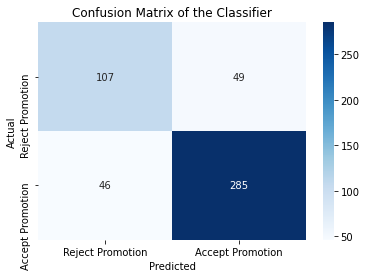

In [31]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = forest_tuned_pred_ca,
          labels = ['Reject Promotion', 'Accept Promotion'])










In [32]:
# Print Total Time
total =  time.time() - start
print(round(total, ndigits = 2))

22.65
